In [1]:
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import fiona
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.style.use("ggplot")

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis()

Connection successful.


# CL Vestland: Summarise and visualise results

## 1. Combine outputs

Merge the two summary CSV generated by the two runs of notebook 03 (handling overlapping polygons).

In [3]:
# Read data
csv_path = r"../output/cl_vestland_results_summary_meqpm2pyr_main_catches.csv"
df1 = pd.read_csv(csv_path)

csv_path = r"../output/cl_vestland_results_summary_meqpm2pyr_sub_catches.csv"
df2 = pd.read_csv(csv_path)

df = pd.concat([df1, df2], sort=False)

# Save combined
csv_path = r"../output/cl_vestland_results_summary_meqpm2pyr.csv"
df.to_csv(csv_path, index=False)

df.head()

,dataset,station_code,min,mean,max,std,count
0,fab_ex_n_2030bc_meqpm2pyr_50m,Eks_Main,0.0,0.00000,0.000000,0.000000,102245
1,fab_ex_n_2030bc_meqpm2pyr_50m,Gud_Main,0.0,4.51825,7.224773,2.342739,105275
2,fab_ex_n_2030bc_meqpm2pyr_50m,Mod_Main,0.0,0.18767,1.608936,0.496311,152332
3,fab_ex_n_2030bc_meqpm2pyr_50m,Sam_Main,0.0,0.00000,0.000000,0.000000,94510
4,fab_ex_n_2030bc_meqpm2pyr_50m,Usk_Main,0.0,0.00000,0.000000,0.000000,18329


## 2. Get catchments

In [4]:
# Get outflows
sql = (
    "SELECT * FROM niva.stations "
    "WHERE station_id IN ( "
    "  SELECT station_id FROM niva.projects_stations "
    "  WHERE project_id IN ( "
    "    SELECT project_id FROM niva.projects "
    "    WHERE project_name = 'CL Vestland' "
    "    ) "
    "  ) "
)
stn_gdf = gpd.read_postgis(sql, eng)

# Reproject to ETRS89 UTM Z33N
stn_gdf = stn_gdf.to_crs("epsg:25833")

stn_gdf.head()

,station_id,station_code,station_name,aquamonitor_id,longitude,latitude,geom
0,1260,Eks_Main,Eksingedal_Main,None,5.793674,60.728518,POINT (-1042.153 6767775.232)
1,1261,Eks_Opp,Eksingedal_Oppstr,None,5.905760,60.792344,POINT (6017.082 6773983.678)
2,1262,Eks_Side,Eksingedal_Side,None,5.806698,60.734305,POINT (-246.174 6768315.730)
3,1263,Gud_Main,Guddal_Main,None,5.345209,61.311320,POINT (-15742.579 6835715.827)
4,1264,Gud_Opp,Guddal_Oppstr,None,5.590573,61.229553,POINT (-4014.772 6824753.423)


In [5]:
# Get catchments
stn_list = list(stn_gdf["station_id"].astype(str))
bind_pars = ",".join(stn_list)
sql = f"SELECT * FROM niva.catchments " f"WHERE station_id IN ({bind_pars})"
cat_gdf = gpd.read_postgis(sql, eng)

# Reproject to ETRS89 UTM Z33N
cat_gdf = cat_gdf.to_crs("epsg:25833")

# Join codes
cat_gdf = cat_gdf.merge(
    stn_gdf[["station_id", "station_code"]], how="left", on="station_id"
)
cat_gdf = cat_gdf[["station_id", "station_code", "geom"]]

cat_gdf.head()

,station_id,station_code,geom
0,1260,Eks_Main,"MULTIPOLYGON (((3082.020 6765260.340, 3036.760..."
1,1261,Eks_Opp,"MULTIPOLYGON (((7265.790 6767632.250, 7240.550..."
2,1262,Eks_Side,"MULTIPOLYGON (((6017.098 6773983.675, 5981.501..."
3,1263,Gud_Main,"MULTIPOLYGON (((-15898.619 6835765.865, -15817..."
4,1264,Gud_Opp,"MULTIPOLYGON (((-1925.930 6823525.440, -1851.4..."


In [6]:
# Use small "intercatchment" for main watershed to avoid visualising overlap
df["station_code"].replace("Sam_Tyss", "Sam_Tyss_IntCat", inplace=True)

# Just need mean
df = df[["dataset", "station_code", "mean"]]

# Join chem to spatial data
gdf = cat_gdf.merge(df, on="station_code", how="right")

gdf

,station_id,station_code,geom,dataset,mean
0,1260,Eks_Main,"MULTIPOLYGON (((3082.020 6765260.340, 3036.760...",fab_ex_n_2030bc_meqpm2pyr_50m,0.000000
1,1260,Eks_Main,"MULTIPOLYGON (((3082.020 6765260.340, 3036.760...",sswc_ex_2030bc_meqpm2pyr_50m,-45.424749
2,1260,Eks_Main,"MULTIPOLYGON (((3082.020 6765260.340, 3036.760...",fab_ex_s_2030bc_meqpm2pyr_50m,0.000000
3,1260,Eks_Main,"MULTIPOLYGON (((3082.020 6765260.340, 3036.760...",fab_ex_reg_id_1216_50m,0.001144
4,1260,Eks_Main,"MULTIPOLYGON (((3082.020 6765260.340, 3036.760...",fab_ex_ns_2030bc_meqpm2pyr_50m,0.000000
...,...,...,...,...,...
595,1284,Ynd_Tang,"MULTIPOLYGON (((-29751.027 6789856.052, -29762...",claoaa_meqpm2pyr_50m,11.807989
596,1284,Ynd_Tang,"MULTIPOLYGON (((-29751.027 6789856.052, -29762...",clmaxnoaa_meqpm2pyr_50m,16.900023
597,1284,Ynd_Tang,"MULTIPOLYGON (((-29751.027 6789856.052, -29762...",clminn_meqpm2pyr_50m,3.438693
598,1284,Ynd_Tang,"MULTIPOLYGON (((-29751.027 6789856.052, -29762...",clmaxsoaa_meqpm2pyr_50m,11.841079


## 3. Create map

In [7]:
def plot_map_data(gdf, ax, title, buff=2000):
    gdf = gdf.copy()
    gdf["mean"] = gdf["mean"].round(0)

    xmin, ymin, xmax, ymax = gdf.total_bounds
    ax.set_extent([xmin - buff, xmax + buff, ymin - buff, ymax + buff], crs=crs)

    # Plot polygons
    gdf.plot(
        column="mean",
        edgecolor="none",
        cmap="plasma",
        # alpha=0.5,
        legend=True,
        # categorical=True,
        ax=ax,
        # legend_kwds={'loc': 'lower right'},
    )

    # Plot outlines
    gdf.plot(
        facecolor="none",
        edgecolor="k",
        lw=1,
        ax=ax,
    )

    #     ax.add_wms(
    #         wms="https://openwms.statkart.no/skwms1/wms.topo4.graatone",
    #         layers=["topo4graatone_WMS"],
    #     )

    ax.set_title(title)

### 3.1. Critical loads

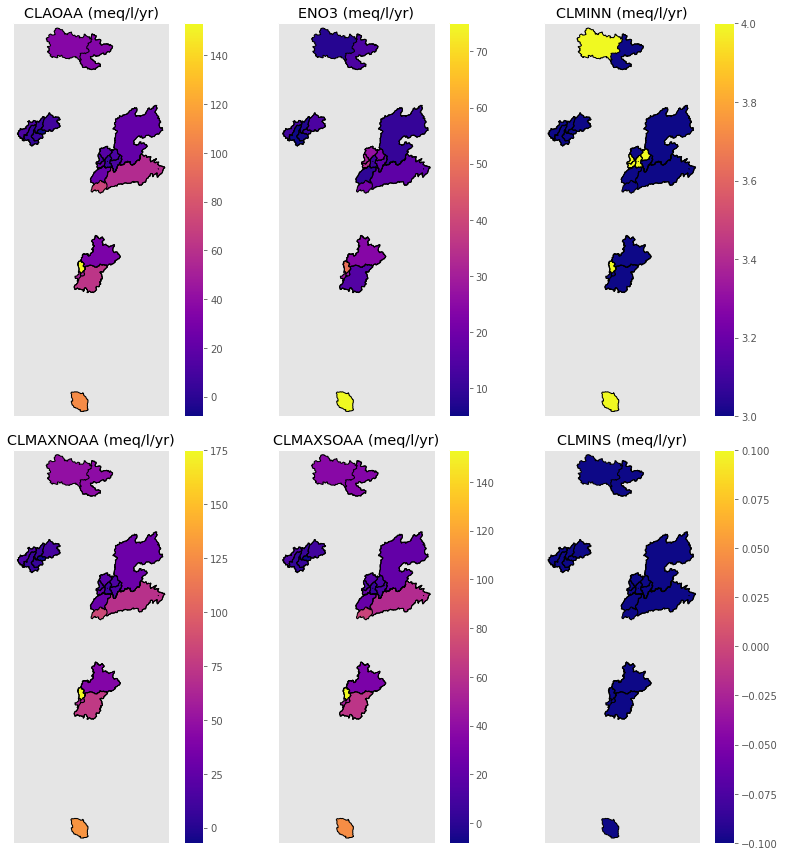

In [8]:
fig = plt.figure(figsize=(12, 12))

# Define co-ord system
crs = ccrs.UTM(33)

pars = ["claoaa", "eno3", "clminn", "clmaxnoaa", "clmaxsoaa", "clmins"]
for idx, par in enumerate(pars):
    ds_name = f"{par}_meqpm2pyr_50m"
    ds_gdf = gdf.query("dataset == @ds_name").copy()
    ax = fig.add_subplot(2, 3, idx + 1, projection=crs)
    plot_map_data(ds_gdf, ax, par.upper() + " (meq/l/yr)")

plt.tight_layout()
png_path = r"../output/png/critical_loads_maps.png"
plt.savefig(png_path, dpi=200)

### 3.2. Deposition

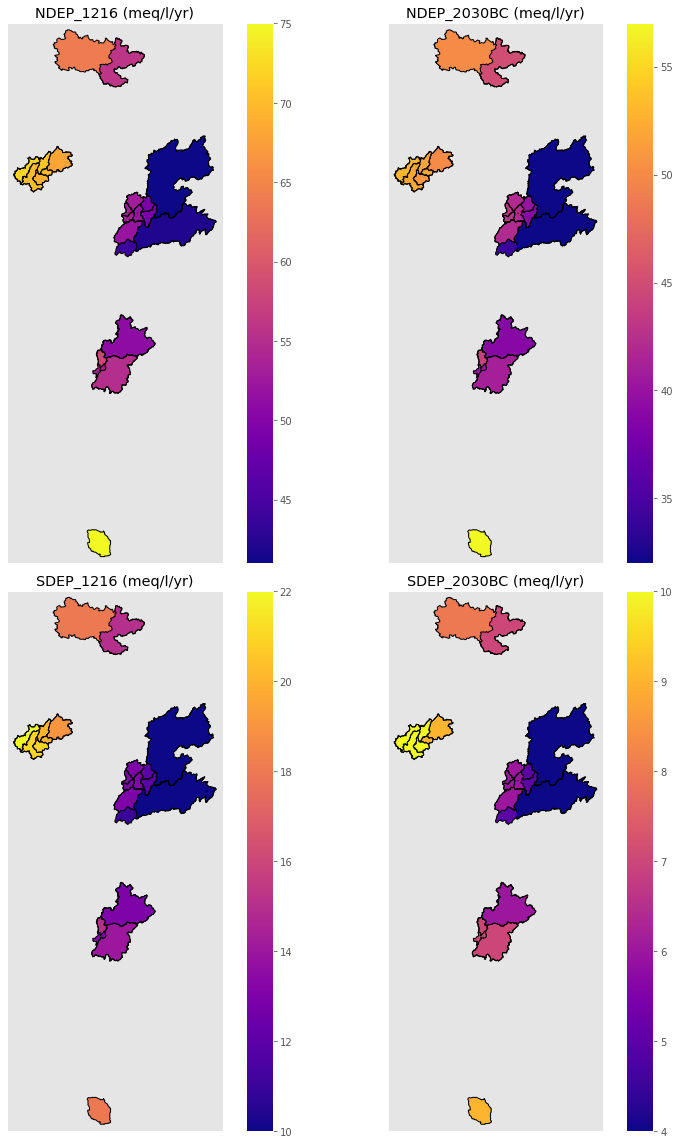

In [9]:
fig = plt.figure(figsize=(12, 16))

# Define co-ord system
crs = ccrs.UTM(33)

pars = ["ndep_1216", "ndep_2030bc", "sdep_1216", "sdep_2030bc"]
for idx, par in enumerate(pars):
    ds_name = f"{par}_meqpm2pyr_50m"
    ds_gdf = gdf.query("dataset == @ds_name")
    ax = fig.add_subplot(2, 2, idx + 1, projection=crs)
    plot_map_data(ds_gdf, ax, par.upper() + " (meq/l/yr)")

plt.tight_layout()
png_path = r"../output/png/deposition_maps.png"
plt.savefig(png_path, dpi=200)

### 3.3. Exceedance

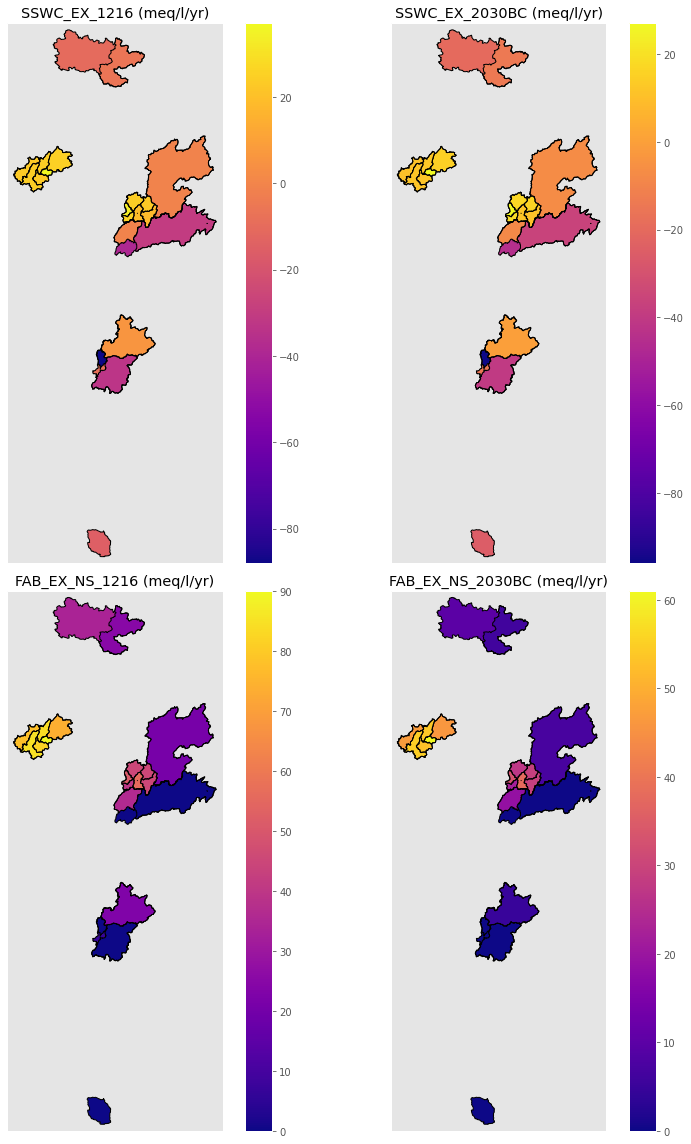

In [10]:
fig = plt.figure(figsize=(12, 16))

# Define co-ord system
crs = ccrs.UTM(33)

pars = ["sswc_ex_1216", "sswc_ex_2030bc", "fab_ex_ns_1216", "fab_ex_ns_2030bc"]
for idx, par in enumerate(pars):
    ds_name = f"{par}_meqpm2pyr_50m"
    ds_gdf = gdf.query("dataset == @ds_name")
    ax = fig.add_subplot(2, 2, idx + 1, projection=crs)
    plot_map_data(ds_gdf, ax, par.upper() + " (meq/l/yr)")

plt.tight_layout()
png_path = r"../output/png/exceedance_maps.png"
plt.savefig(png_path, dpi=200)